In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

In [2]:
#Import South Park Script
southpark = pd.read_csv("All-seasons.csv")
southpark.head()

,Season,Episode,Character,Line
0,1,1,Boys,"School day, school day, teacher's golden ru...\n"
1,1,1,Kyle,"Ah, damn it! My little brother's trying to fol..."
2,1,1,Ike,Zeeponanner.\n
3,1,1,Kyle,"Ike, you can't come to school with me. \n"
4,1,1,Cartman,"Yeah, go home you little dildo.\n"


In [3]:
#Dialogue spoken by Cartman
cart = southpark['Character'] == 'Cartman'
cartman = southpark[cart]
cartman.head()

,Season,Episode,Character,Line
4,1,1,Cartman,"Yeah, go home you little dildo.\n"
8,1,1,Cartman,I know what it means!\n
10,1,1,Cartman,I'm not telling you.\n
13,1,1,Cartman,"He-yeah, that's what Kyle's little brother is ..."
19,1,1,Cartman,That's 'cause I was having these... bogus nigh...


In [4]:
#Reset index
cartman = cartman.reset_index(drop=True)
cartman.head()

,Season,Episode,Character,Line
0,1,1,Cartman,"Yeah, go home you little dildo.\n"
1,1,1,Cartman,I know what it means!\n
2,1,1,Cartman,I'm not telling you.\n
3,1,1,Cartman,"He-yeah, that's what Kyle's little brother is ..."
4,1,1,Cartman,That's 'cause I was having these... bogus nigh...


In [5]:
#Lowercase
cartman['Line_process'] = cartman['Line'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cartman['Line_process'].head()

0                      yeah, go home you little dildo.
1                                i know what it means!
2                                 i'm not telling you.
3    he-yeah, that's what kyle's little brother is ...
4    that's 'cause i was having these... bogus nigh...
Name: Line_process, dtype: object

In [6]:
#Remove Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
cartman['Line_process'] = cartman['Line_process'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
cartman['Line_process'].head(25)

0                           yeah, go home little dildo.
1                                           know means!
2                                      i'm telling you.
3      he-yeah, that's kyle's little brother right! ow!
4              that's 'cause these... bogus nightmares.
5     well, dreamt lying bed... dark, sudden bright ...
6                                                 what?
7                               no, dream, mom said so.
8           oh, shut guys! trying make scared. working.
9                                             kick ass.
10                                                 huh?
11         eh, no, that, dream. i'm fat, i'm big boned!
12                                                  oh!
13                                                  oh!
14                       no! uh-i mean, eh, would that?
15                                                  no!
16                                      shut up, dildo!
17                                              

In [7]:
#Remove Punctuation
cartman['Line_process'] = cartman['Line_process'].str.replace('[^\w\s]','')
cartman['Line_process'].head(25)

0                             yeah go home little dildo
1                                            know means
2                                        im telling you
3            heyeah thats kyles little brother right ow
4                    thats cause these bogus nightmares
5     well dreamt lying bed dark sudden bright blue ...
6                                                  what
7                                  no dream mom said so
8               oh shut guys trying make scared working
9                                              kick ass
10                                                  huh
11                 eh no that dream im fat im big boned
12                                                   oh
13                                                   oh
14                            no uhi mean eh would that
15                                                   no
16                                        shut up dildo
17                                              

In [8]:
#Tokenize
cartman['word_tokens'] = cartman['Line_process'].apply(word_tokenize)
cartman['sent_tokens'] = cartman['Line'].apply(sent_tokenize)

In [9]:
cartman['word_tokens'].head(25)

0                       [yeah, go, home, little, dildo]
1                                         [know, means]
2                                    [im, telling, you]
3     [heyeah, thats, kyles, little, brother, right,...
4              [thats, cause, these, bogus, nightmares]
5     [well, dreamt, lying, bed, dark, sudden, brigh...
6                                                [what]
7                            [no, dream, mom, said, so]
8       [oh, shut, guys, trying, make, scared, working]
9                                           [kick, ass]
10                                                [huh]
11       [eh, no, that, dream, im, fat, im, big, boned]
12                                                 [oh]
13                                                 [oh]
14                     [no, uhi, mean, eh, would, that]
15                                                 [no]
16                                    [shut, up, dildo]
17                                              

In [10]:
#Lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
cartman['word_tokens'].apply(lemmatize_text).head(25)

0                       [yeah, go, home, little, dildo]
1                                          [know, mean]
2                                    [im, telling, you]
3     [heyeah, thats, kyles, little, brother, right,...
4               [thats, cause, these, bogus, nightmare]
5     [well, dreamt, lying, bed, dark, sudden, brigh...
6                                                [what]
7                            [no, dream, mom, said, so]
8        [oh, shut, guy, trying, make, scared, working]
9                                            [kick, as]
10                                                [huh]
11       [eh, no, that, dream, im, fat, im, big, boned]
12                                                 [oh]
13                                                 [oh]
14                     [no, uhi, mean, eh, would, that]
15                                                 [no]
16                                    [shut, up, dildo]
17                                              

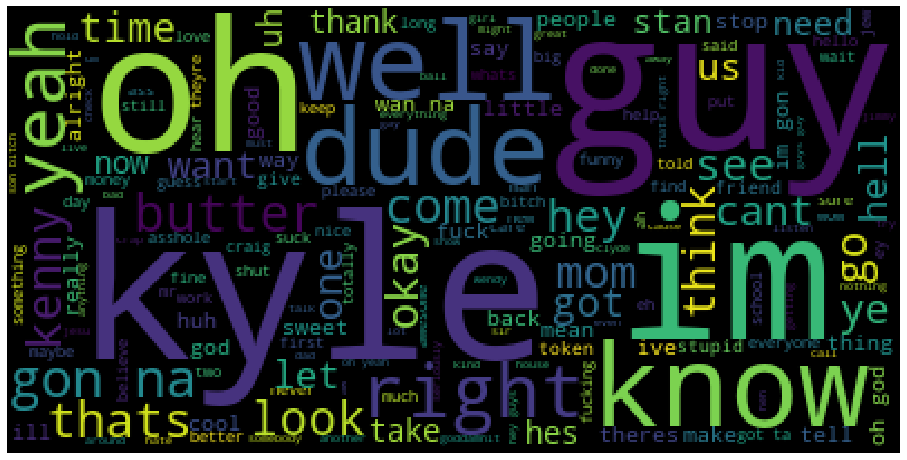

In [11]:
#Wordcloud
wordcloud_cartman = WordCloud().generate(cartman['word_tokens'].to_string())
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud_cartman)
plt.axis("off")
plt.show()

In [12]:
#Bag of Word Model
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
vec = CountVectorizer().fit(cartman['Line_process'])
bag_of_words = vec.transform(cartman['Line_process'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = np.array(sorted(words_freq, key = lambda x: x[1], reverse=True))

([<matplotlib.axis.YTick at 0x27791036d48>,
 <a list of 25 Text yticklabel objects>)

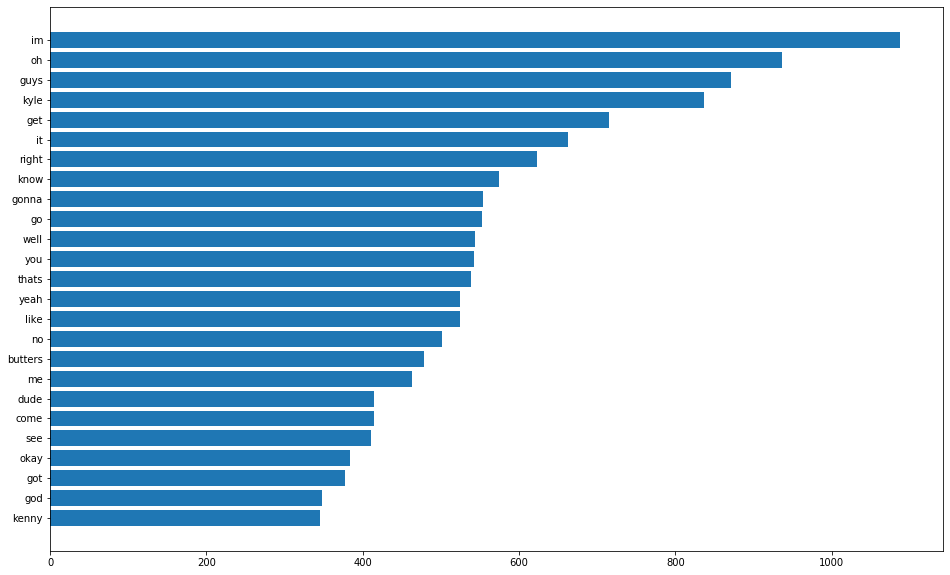

In [14]:
n = 25
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), words_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=words_freq[:n, 0])

In [15]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer  
vect = TfidfVectorizer().fit(cartman['Line_process'])
tfidf = vect.transform(cartman['Line_process'])
sum_tfidf = tfidf.sum(axis=0)
tfidf_freq = [(word, sum_tfidf[0, idx]) for word, idx in vect.vocabulary_.items()]
tfidf_freq = np.array(sorted(tfidf_freq, key = lambda x: x[1], reverse=True))

([<matplotlib.axis.YTick at 0x2779110a108>,
 <a list of 25 Text yticklabel objects>)

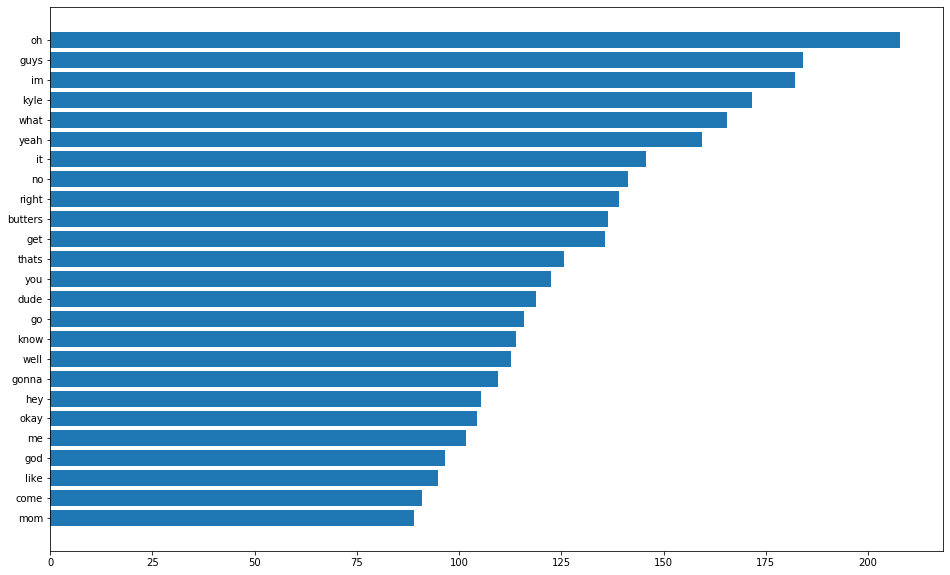

In [16]:
n = 25
plt.figure(figsize=(16, 10))
plt.barh(-np.arange(n), tfidf_freq[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=tfidf_freq[:n, 0])

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
# Chatbot

In [19]:
#Greeting
GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]
def greeting(sentence):
 
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [20]:
#Response
def response(user_response):
    robo_response=''
    cartman['sent_tokens'].append(user_response)
    TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
    tfidf = TfidfVec.fit_transform(cartman['sent_tokens'])
    vals = cosine_similarity(tfidf[-1], tfidf)
    idx=vals.argsort()[0][-2]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    if(req_tfidf==0):
        robo_response=robo_response+"I am sorry! I don't understand you"
        return robo_response
    else:
        robo_response = robo_response+sent_tokens[idx]
        return robo_response

In [21]:
#Starting and Ending Conversation
flag=True
print("Cartman: My name is Cartman. I will answer your queries about Chatbots. If you want to exit, type Bye!")
while(flag==True):
    user_response = input()
    user_response=user_response.lower()
    if(user_response!='bye'):
        if(user_response=='thanks' or user_response=='thank you' ):
            flag=False
            print("Cartman: You are welcome..")
        else:
            if(greeting(user_response)!=None):
                print("Cartman: "+greeting(user_response))
            else:
                print("Cartman: ",end="")
                print(response(user_response))
                sent_tokens.remove(user_response)
    else:
        flag=False
        print("Cartman: Bye! take care..")

Cartman: My name is Cartman. I will answer your queries about Chatbots. If you want to exit, type Bye!
hi
Cartman: hi
kyle
Cartman: 

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid